<a href="https://colab.research.google.com/github/nmermigas/PyTorch/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets

## 0. Importing PyTorch and setting up device agnostic code

In [1]:
import torch
from torch import nn

torch.__version__

'2.1.0+cu118'

In [2]:
# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
!nvidia-smi

Sat Nov 11 16:10:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Get data

A good practice is to start small ( get a subset of the dataset ) and then upscale to the full dataset.

The dataset is a subset of Food101 dataset.

Food101 has 101 different classes of food and 1000 images per classe (750 training, 250 testing).

Our dataset starts with 3 classes of foof and only 10% of the images ( ~75 training, 25 testing).


In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [5]:
image_path

PosixPath('data/pizza_steak_sushi')

## 2. Becoming one with the data (data prep and data exploration)

In [6]:
import os
def walk_trhough_dir(dir_path):
  """Walks through dir_path returning its content"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [7]:
walk_trhough_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi


In [8]:
# Setup train and testing paths
train_dir = image_path/"train"
test_dir = image_path / "test"

In [9]:
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Visualizing and image

Let's write some code to:

1. Get all of the image paths
2. Piack a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Open the image with Python's PIL

Random image path: data/pizza_steak_sushi/train/sushi/2674024.jpg
Image class: sushi
Image height: 384
Image width: 512
Image shape: (384, 512, 3)


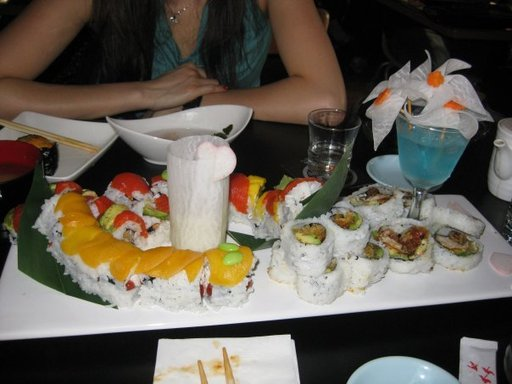

In [10]:
import random
import numpy as np
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. pick a random image
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (aka the name of the directory) (.parent gives the full path and .stem the last dir)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
image_as_array = np.asarray(img)
print(f"Image shape: {image_as_array.shape}")


img

## 3. Transforming data

Before using the image data with PyTorch:

1. Turn the target data into tensors (in our case, numerical representation of the images)

2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.Dataloader`.

We'll call these `Dataset` and `DataLoader` respectively.

In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


## 3.1 Transforming data with `torchvision.transforms`

In [12]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [13]:
data_transform(img)

tensor([[[0.0275, 0.0353, 0.1020,  ..., 0.0157, 0.0392, 0.1765],
         [0.0275, 0.0196, 0.0314,  ..., 0.0510, 0.0353, 0.0314],
         [0.0196, 0.0235, 0.0235,  ..., 0.1098, 0.0275, 0.0196],
         ...,
         [0.0863, 0.1059, 0.4549,  ..., 0.0196, 0.0157, 0.0157],
         [0.0706, 0.1020, 0.4510,  ..., 0.0235, 0.0196, 0.0196],
         [0.0471, 0.1020, 0.4549,  ..., 0.0196, 0.0196, 0.0157]],

        [[0.0314, 0.0314, 0.0902,  ..., 0.0196, 0.0392, 0.1608],
         [0.0314, 0.0196, 0.0275,  ..., 0.0431, 0.0314, 0.0353],
         [0.0196, 0.0235, 0.0235,  ..., 0.0863, 0.0275, 0.0275],
         ...,
         [0.0902, 0.1020, 0.3843,  ..., 0.0196, 0.0157, 0.0157],
         [0.0706, 0.0902, 0.3686,  ..., 0.0235, 0.0196, 0.0196],
         [0.0431, 0.0980, 0.3765,  ..., 0.0196, 0.0196, 0.0157]],

        [[0.0196, 0.0275, 0.0745,  ..., 0.0157, 0.0314, 0.1059],
         [0.0196, 0.0235, 0.0196,  ..., 0.0314, 0.0235, 0.0275],
         [0.0157, 0.0196, 0.0235,  ..., 0.0627, 0.0196, 0.

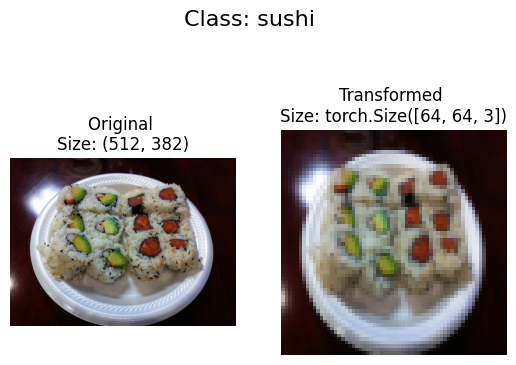

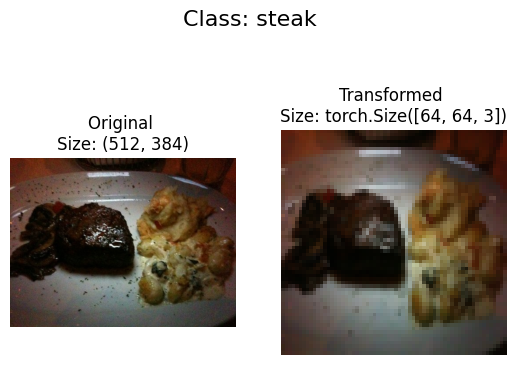

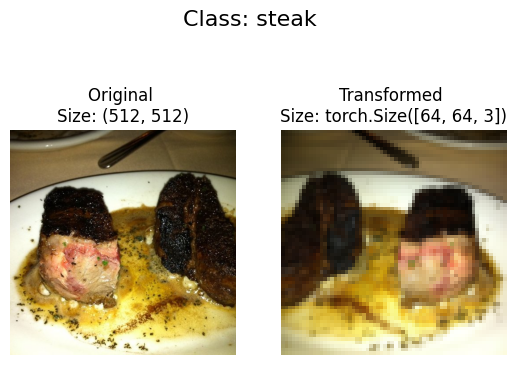

In [14]:
import matplotlib.pyplot as plt

def plot_transformed_images(image_paths, transform, n=3,seed=42):
  """
  Selects random images from a path then loads/transforms
  them then plots the original vs the transformed version
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot image
      transformed_image = transform(f).permute(1,2,0) # we do this to bring the color channels to the last position : (C,H,W) -> (H,W,C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis('off')

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths = image_path_list,
                        transform = data_transform,
                        n=3,
                        seed=42)


## 4. Option 1: Loading image using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [15]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform = data_transform, # transform for the data
                                  target_transform = None) # transform for the label/target

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [16]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [17]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [18]:
# Get class names as a list
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
# Check the lengths of our dataset
len(train_data), len(test_data)


(225, 75)

### 4.1 Turn loaded images into `Dataloaders`

A data loader is going to help us turn datasets into iterables and

In [20]:
# Turn train and test datasets into Dataloaders
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset = train_data,
                              batch_size= BATCH_SIZE,
                              num_workers = 1,
                              shuffle=True)
test_dataloader = DataLoader(dataset = test_data,
                              batch_size= BATCH_SIZE,
                              num_workers = 1,
                              shuffle=False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b1478f882e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7b1478f88ee0>)

In [21]:
len(train_dataloader)

225

In [22]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1
print(f"Image shape: {img.shape} -> [batch_size,color_channels,height, width]")
print(f"Image shape: {label.shape}")


Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size,color_channels,height, width]
Image shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* It doesn't mean it will work...
* Using a custom `Dataset` often results in writing more code -> prone to errors

All custom datasets in PyTorch often subclass - https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset


In [23]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [24]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory.
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure)
3. Turn the class names into a dict and a list and return them.

In [25]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [28]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str,int]]:
  """Finds the class folder names in a target directory. """
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couln't find any classes in {directory}")

  # 3. Create a dict of index labels
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [29]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To do this, we will:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory as well as a transform if we'd like to transform the data
3. Create several attributes:
  * paths - paths of our images
  * transform - the transform we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function `load_images()`
5. Overwrite the `__len__()` method to return the length of the dataset
6. Overwrite the `__getitem__()` method to return a given sample when passes an index

In [37]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # Initialize the custrom dataset
  def __init__(self,
              targ_dir:str,
              transform = None):
    # 3. Create class attributes
    # Get all paths of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup tansform
    self.transforms = transform
    # Create classes and class_to_idx
    self.classes , self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index:int) -> Image.Image:
    """ Opens an image via a path and returns it"""
    image_path = self.paths[index]
    return Image.open(image_path)
  # 5. Overwrite __len__()
  def __len__(self) ->int:
    return len(self.paths)
  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index:int)->Tuple[torch.Tensor,int]:
    """ Returns one sample of data, data and label (X,y) """
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]
    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X,y)
    else:
      return img, class_idx # return untransformed image, label

In [38]:
# Create a transform
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])




In [39]:
# Test the ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir = train_dir,
                                      transform = train_transforms)

test_data_custom = ImageFolderCustom(targ_dir = test_dir,
                                      transform = test_transforms)

In [40]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7b147b0d0eb0>,
 <__main__.ImageFolderCustom at 0x7b147b0d1270>)

In [41]:
len(train_data),len(train_data_custom)

(225, 225)

In [48]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom Dataset
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)


True
True
